In [1]:
import sys, os
sys.path.append(os.path.abspath(".."))  # add project root

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score

pd.set_option("display.float_format", lambda x: "%.2f" % x)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
plt.style.use("seaborn-v0_8-whitegrid")

from pipelines.pipeline_runner import run_full_pipeline_with_split  
from utils.ml_utils import prepare_X_y  




In [2]:
# Run leakage-safe pipeline with Stage0 → Stage1 → Stage2 → split → Stage3Fitter
dfs = run_full_pipeline_with_split()

df_stage1 = dfs["stage1"]
df_stage2 = dfs["stage2"]

df_train = dfs["train"]
df_val   = dfs["val"]
df_test  = dfs["test"]



In [3]:
def evaluate_regression(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    print(f"===== {name} =====")
    print(f"MAE: {mae:,.2f}")
    print(f"R² : {r2:.4f}")
    return mae, r2


def plot_regression_diagnostics(y_true, y_pred, title_prefix="Model"):
    residuals = y_true - y_pred

    fig, axes = plt.subplots(1, 3, figsize=(22, 6))

    # 1) Actual vs Predicted
    axes[0].scatter(y_true, y_pred, alpha=0.4)
    min_v = min(y_true.min(), y_pred.min())
    max_v = max(y_true.max(), y_pred.max())
    axes[0].plot([min_v, max_v], [min_v, max_v], "r--", linewidth=2)
    axes[0].set_title(f"{title_prefix} — Actual vs Predicted")
    axes[0].set_xlabel("Actual Price")
    axes[0].set_ylabel("Predicted Price")

    # 2) Residual Distribution
    sns.histplot(residuals, kde=True, bins=40, ax=axes[1], color="steelblue")
    axes[1].set_title(f"{title_prefix} — Residual Distribution")
    axes[1].set_xlabel("Residual (Actual - Predicted)")

    # 3) Residuals vs Predicted
    axes[2].scatter(y_pred, residuals, alpha=0.4)
    axes[2].axhline(0, color="red", linestyle="--", linewidth=2)
    axes[2].set_title(f"{title_prefix} — Residuals vs Predicted")
    axes[2].set_xlabel("Predicted Price")
    axes[2].set_ylabel("Residual")

    plt.tight_layout()
    plt.show()


def plot_lr_feature_importance(model, feature_names, top_n=20, title="LR Coefficients"):
    """
    model: fitted LinearRegression (from pipeline.named_steps["model"])
    feature_names: list/Index of feature names (X.columns)
    """
    coefs = model.coef_
    features = np.array(feature_names)

    idx = np.argsort(np.abs(coefs))[::-1][:top_n]
    top_features = features[idx]
    top_coefs = coefs[idx]

    plt.figure(figsize=(10, 6))
    y_pos = np.arange(len(top_features))
    plt.barh(y_pos, top_coefs)
    plt.yticks(y_pos, top_features)
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel("Coefficient value")
    plt.tight_layout()
    plt.show()


def plot_tree_importances(model, feature_names, top_n=30, title="Random Forest — Feature Importances"):
    importances = model.feature_importances_
    features = np.array(feature_names)
    idx = np.argsort(importances)[::-1][:top_n]
    top_features = features[idx]
    top_importances = importances[idx]

    plt.figure(figsize=(12, 10))
    y_pos = np.arange(len(top_features))
    plt.barh(y_pos, top_importances)
    plt.yticks(y_pos, top_features)
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()



--- Linear Regression (Train) ---
===== LR — Train =====
MAE: 85,122.32
R² : 0.6331

--- Linear Regression (Validation) ---
===== LR — Validation =====
MAE: 93,278.84
R² : 0.5872

--- Linear Regression (Test) ---
===== LR — Test =====
MAE: 88,268.21
R² : 0.6592


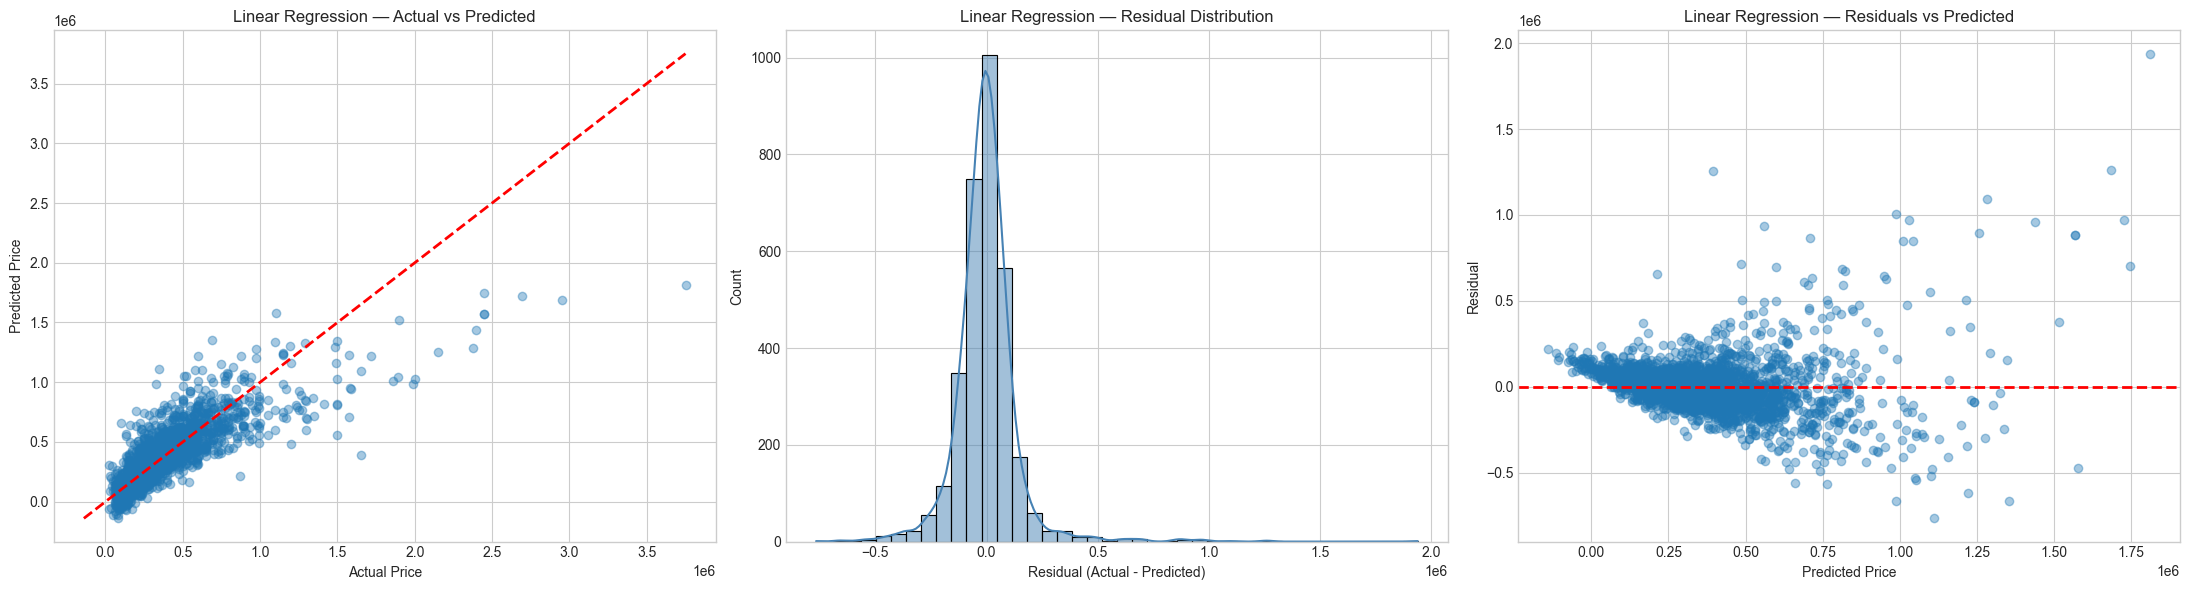

In [4]:
# ============================================================
# LINEAR REGRESSION — TRAIN / VAL / TEST
# ============================================================

# Build X, y from Stage 3 outputs
X_train_lr, y_train_lr = prepare_X_y(df_train, model_type="linear")
X_val_lr,   y_val_lr   = prepare_X_y(df_val,   model_type="linear")
X_test_lr,  y_test_lr  = prepare_X_y(df_test,  model_type="linear")


# Pipeline: Impute (median) + Linear Regression
lr_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("model", LinearRegression())
    ]
)

# Fit on TRAIN only
lr_pipeline.fit(X_train_lr, y_train_lr)

# Evaluate on TRAIN, VAL, TEST
y_pred_train_lr = lr_pipeline.predict(X_train_lr)
y_pred_val_lr   = lr_pipeline.predict(X_val_lr)
y_pred_test_lr  = lr_pipeline.predict(X_test_lr)

print("\n--- Linear Regression (Train) ---")
evaluate_regression("LR — Train", y_train_lr, y_pred_train_lr)

print("\n--- Linear Regression (Validation) ---")
evaluate_regression("LR — Validation", y_val_lr, y_pred_val_lr)

print("\n--- Linear Regression (Test) ---")
evaluate_regression("LR — Test", y_test_lr, y_pred_test_lr)

# Diagnostics plots on TEST
plot_regression_diagnostics(y_test_lr, y_pred_test_lr, title_prefix="Linear Regression")


Shapes (RF):
X_train: (15030, 76)  y_train: (15030,)
X_val  : (3221, 76)  y_val  : (3221,)
X_test : (3221, 76)  y_test : (3221,)

NaNs in X_train (before imputer): 0

--- Random Forest (Train) ---
===== RF — Train =====
MAE: 17,837.54
R² : 0.9761

--- Random Forest (Validation) ---
===== RF — Validation =====
MAE: 53,014.81
R² : 0.8348

--- Random Forest (Test) ---
===== RF — Test =====
MAE: 51,099.96
R² : 0.8001


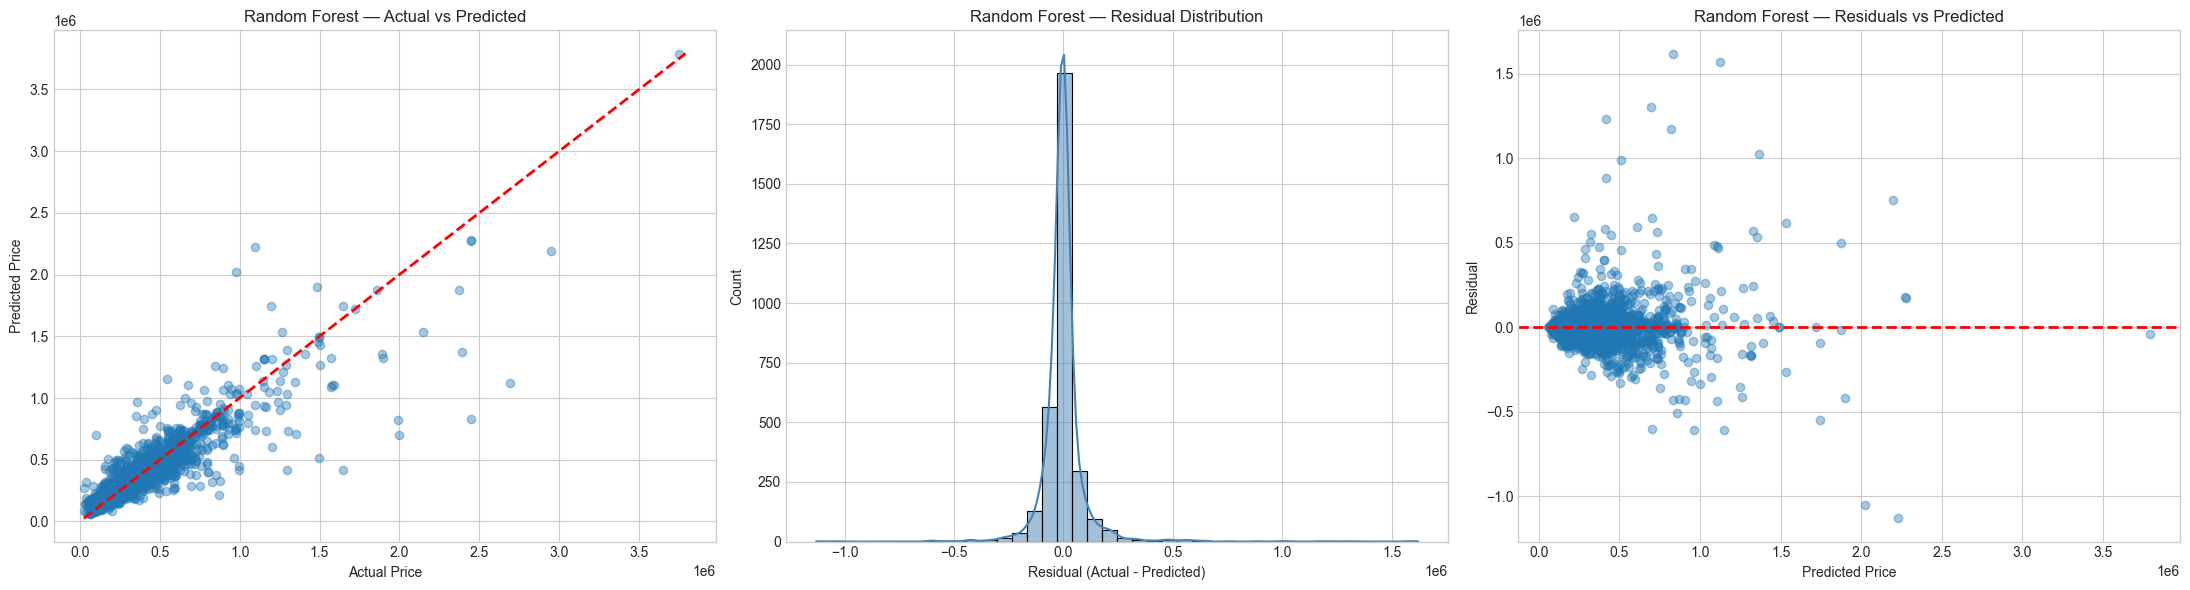

In [8]:
# ============================================================
# RANDOM FOREST — TRAIN / VAL / TEST
# ============================================================

X_train_rf, y_train_rf = prepare_X_y(df_train, model_type="rf")
X_val_rf,   y_val_rf   = prepare_X_y(df_val,   model_type="rf")
X_test_rf,  y_test_rf  = prepare_X_y(df_test,  model_type="rf")

print("Shapes (RF):")
print("X_train:", X_train_rf.shape, " y_train:", y_train_rf.shape)
print("X_val  :", X_val_rf.shape,   " y_val  :", y_val_rf.shape)
print("X_test :", X_test_rf.shape,  " y_test :", y_test_rf.shape)

print("\nNaNs in X_train (before imputer):", int(X_train_rf.isna().sum().sum()))

# Pipeline: Impute (median) + RandomForest
rf_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("model", RandomForestRegressor(
            n_estimators=300,
            random_state=42,
            n_jobs=-1
        ))
    ]
)

# Fit on TRAIN
rf_pipeline.fit(X_train_rf, y_train_rf)

# Predict
y_pred_train_rf = rf_pipeline.predict(X_train_rf)
y_pred_val_rf   = rf_pipeline.predict(X_val_rf)
y_pred_test_rf  = rf_pipeline.predict(X_test_rf)

print("\n--- Random Forest (Train) ---")
evaluate_regression("RF — Train", y_train_rf, y_pred_train_rf)

print("\n--- Random Forest (Validation) ---")
evaluate_regression("RF — Validation", y_val_rf, y_pred_val_rf)

print("\n--- Random Forest (Test) ---")
evaluate_regression("RF — Test", y_test_rf, y_pred_test_rf)

# Diagnostics on TEST
plot_regression_diagnostics(y_test_rf, y_pred_test_rf, title_prefix="Random Forest")



--- XGBoost (Train) ---
===== XGBoost — Train =====
MAE: 17,672.17
R² : 0.9906

--- XGBoost (Validation) ---
===== XGBoost — Validation =====
MAE: 48,667.18
R² : 0.8714

--- XGBoost (Test) ---
===== XGBoost — Test =====
MAE: 47,966.51
R² : 0.8277


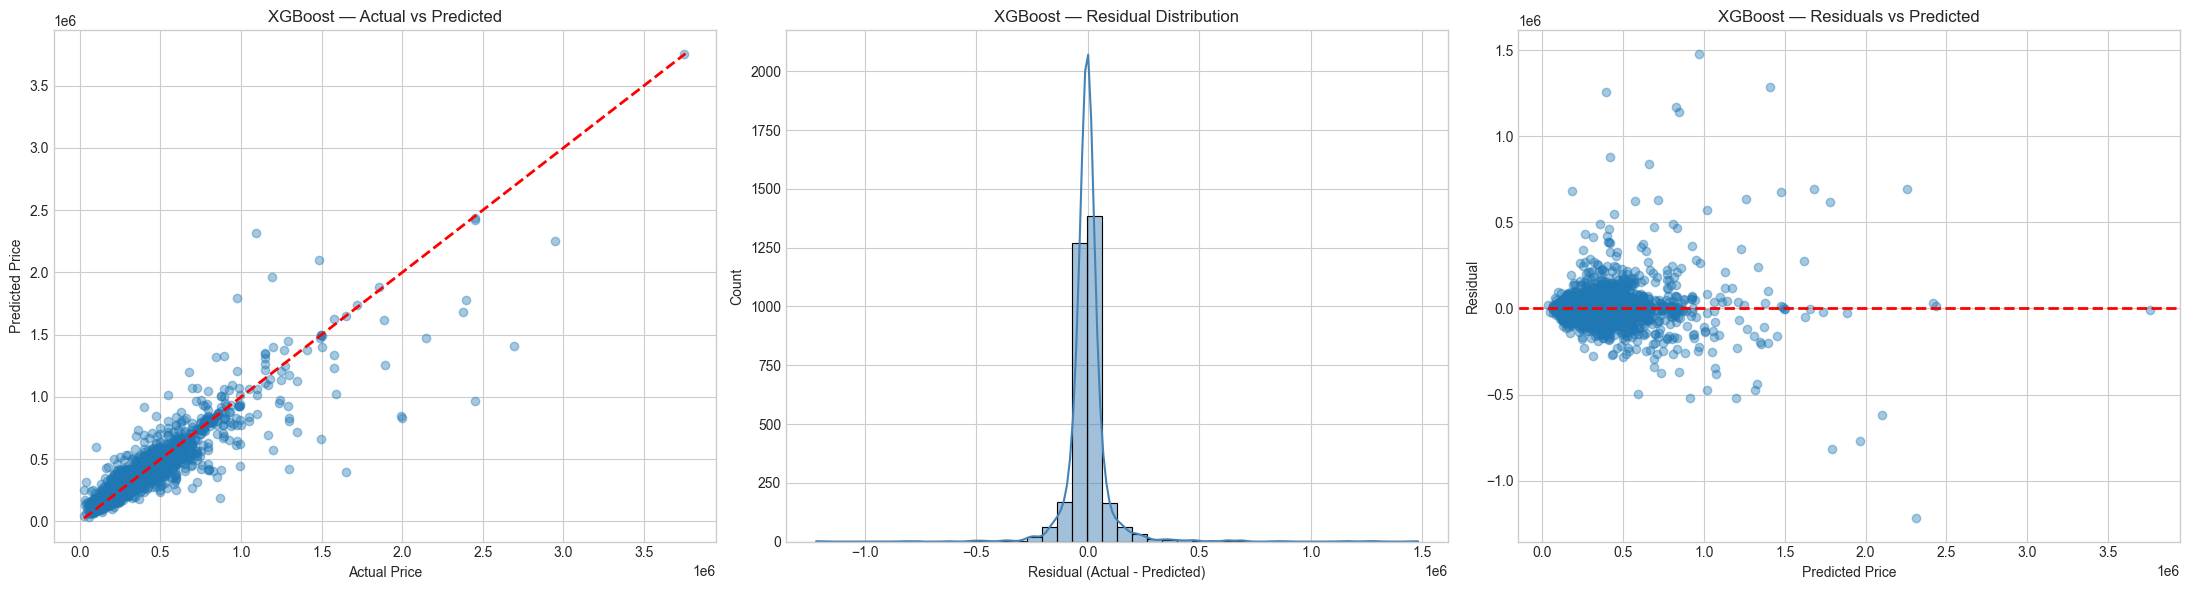

In [ ]:
# ============================================================
# XGBOOST REGRESSOR — TRAIN / VAL / TEST
# ============================================================

from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Build X, y (tree-based → use model_type="rf")
X_train_xgb, y_train_xgb = prepare_X_y(df_train, model_type="rf")
X_val_xgb,   y_val_xgb   = prepare_X_y(df_val,   model_type="rf")
X_test_xgb,  y_test_xgb  = prepare_X_y(df_test,  model_type="rf")


# Pipeline: Imputer + XGBoost
xgb_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),  # optional: XGB handles NaNs
        ("model", XGBRegressor(
            n_estimators=400,
            learning_rate=0.05,
            max_depth=8,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            objective="reg:squarederror"
        ))
    ]
)

# Fit
xgb_pipeline.fit(X_train_xgb, y_train_xgb)

# Predict
y_pred_train_xgb = xgb_pipeline.predict(X_train_xgb)
y_pred_val_xgb   = xgb_pipeline.predict(X_val_xgb)
y_pred_test_xgb  = xgb_pipeline.predict(X_test_xgb)

# Evaluate
print("\n--- XGBoost (Train) ---")
evaluate_regression("XGBoost — Train", y_train_xgb, y_pred_train_xgb)

print("\n--- XGBoost (Validation) ---")
evaluate_regression("XGBoost — Validation", y_val_xgb, y_pred_val_xgb)

print("\n--- XGBoost (Test) ---")
evaluate_regression("XGBoost — Test", y_test_xgb, y_pred_test_xgb)

# Diagnostics on TEST
plot_regression_diagnostics(y_test_xgb, y_pred_test_xgb, title_prefix="XGBoost")


In [ ]:
# ============================================================
# XGBOOST FEATURE IMPORTANCE
# ============================================================

xgb_model = xgb_pipeline.named_steps["model"]
importances = xgb_model.feature_importances_

plot_tree_importances(
    xgb_model,
    X_train_xgb.columns,
    top_n=30,
    title="XGBoost — Top 30 Feature Importances"
)


In [ ]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, mean_absolute_error

# ============================================================
# 0. Prepare data (from Stage2 → Stage3 split)
# ============================================================
X_train_xgb, y_train_xgb = prepare_X_y(df_train, model_type="rf")
X_val_xgb,   y_val_xgb   = prepare_X_y(df_val,   model_type="rf")
X_test_xgb,  y_test_xgb  = prepare_X_y(df_test,  model_type="rf")

# ============================================================
# 1. Build XGBoost tuning pipeline
# ============================================================
xgb_tune_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),  # XGB can handle NaN but keep consistent
        ("model", XGBRegressor(
            random_state=42,
            n_jobs=-1,
            objective="reg:squarederror",
            tree_method="hist"  # fastest option
        ))
    ]
)

# ============================================================
# 2. VERY light tuning grid (fast, meaningful)
# ============================================================
param_grid = {
    "model__n_estimators": [300, 400, 500],
    "model__learning_rate": [0.05, 0.1],
    "model__max_depth": [6, 10],
    "model__subsample": [0.8],
    "model__colsample_bytree": [0.8]
}

# ============================================================
# 3. 3-Fold CV setup
# ============================================================
cv = KFold(n_splits=3, shuffle=True, random_state=42)

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

grid = GridSearchCV(
    estimator=xgb_tune_pipeline,
    param_grid=param_grid,
    scoring=mae_scorer,   # MAE for real estate stability
    cv=cv,
    n_jobs=-1,
    verbose=2
)

# ============================================================
# 4. Run grid search — TRAIN ONLY (no leakage)
# ============================================================
print("\nRunning XGBoost tuning...")
grid.fit(X_train_xgb, y_train_xgb)

print("\nBest Hyperparameters:")
print(grid.best_params_)
print("Best CV MAE:", abs(grid.best_score_))

# ============================================================
# 5. Refit best model on full TRAIN
# ============================================================
best_xgb = grid.best_estimator_

# ============================================================
# 6. Predict on Train / Val / Test
# ============================================================
y_pred_train_xgb = best_xgb.predict(X_train_xgb)
y_pred_val_xgb   = best_xgb.predict(X_val_xgb)
y_pred_test_xgb  = best_xgb.predict(X_test_xgb)

# ============================================================
# 7. Evaluate
# ============================================================
print("\n--- XGBoost (Train, tuned) ---")
evaluate_regression("XGB — Train (tuned)", y_train_xgb, y_pred_train_xgb)

print("\n--- XGBoost (Validation, tuned) ---")
evaluate_regression("XGB — Validation (tuned)", y_val_xgb, y_pred_val_xgb)

print("\n--- XGBoost (Test, tuned) ---")
evaluate_regression("XGB — Test (tuned)", y_test_xgb, y_pred_test_xgb)

# Diagnostics
plot_regression_diagnostics(y_test_xgb, y_pred_test_xgb, title_prefix="XGB Tuned")


In [7]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import (
    make_scorer,
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
import numpy as np

# ============================================================
# 0. Rebuild your BEST XGBoost model
# ============================================================
best_xgb_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("model", XGBRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=10,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            objective="reg:squarederror",
            tree_method="hist"
        ))
    ]
)

# ============================================================
# 1. 5-Fold CV setup
# ============================================================
cv = KFold(n_splits=5, shuffle=True, random_state=4)

scoring = {
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "RMSE": make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)), 
                        greater_is_better=False),
    "R2": make_scorer(r2_score)
}

# ============================================================
# 2. Run the 5-Fold CV
# ============================================================
cv_results = cross_validate(
    estimator=best_xgb_pipeline,
    X=X_train_xgb,
    y=y_train_xgb,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    verbose=2
)

# ============================================================
# 3. Print results
# ============================================================
print("\n========== 5-FOLD CROSS VALIDATION RESULTS (BEST XGBOOST) ==========\n")

for metric in ["MAE", "RMSE", "R2"]:
    mean_score = abs(cv_results[f"test_{metric}"]).mean() if metric != "R2" else cv_results[f"test_{metric}"].mean()
    std_score = abs(cv_results[f"test_{metric}"]).std() if metric != "R2" else cv_results[f"test_{metric}"].std()

    print(f"{metric}:  {mean_score:.4f} ± {std_score:.4f}")

print("\n====================================================================")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



========== 5-FOLD CROSS VALIDATION RESULTS (BEST XGBOOST) ==========

MAE:  43981.9173 ± 1859.7563
RMSE:  103489.4060 ± 16728.9193
R2:  0.8426 ± 0.0333



[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   56.7s finished


## Full leakage test: Reverse test — Shuffle Target Test

In [13]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ============================================================
# 0. Your BEST XGBoost pipeline (unchanged)
# ============================================================
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

best_xgb_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("model", XGBRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=10,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            objective="reg:squarederror",
            tree_method="hist"
        ))
    ]
)

# ============================================================
# 1. SHUFFLE TARGET LEAKAGE TEST
# ============================================================
def leakage_shuffle_test(model, X_train, y_train, X_test, y_test):

    # ---- Step 1: Shuffle the target ----
    y_train_shuffled = shuffle(y_train, random_state=4)
    y_test_shuffled  = shuffle(y_test,  random_state=4)

    # ---- Step 2: Fit model on SHUFFLED target ----
    model.fit(X_train, y_train_shuffled)

    # ---- Step 3: Predictions ----
    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)

    # ---- Step 4: Metrics ----
    train_r2  = r2_score(y_train_shuffled, y_pred_train)
    test_r2   = r2_score(y_test_shuffled,  y_pred_test)

    train_mae = mean_absolute_error(y_train_shuffled, y_pred_train)
    test_mae  = mean_absolute_error(y_test_shuffled,  y_pred_test)

    train_rmse = np.sqrt(mean_squared_error(y_train_shuffled, y_pred_train))
    test_rmse  = np.sqrt(mean_squared_error(y_test_shuffled,  y_pred_test))

    print("\n========== SHUFFLED TARGET — LEAKAGE TEST ==========")
    print("Train R²:      ", round(train_r2, 4))
    print("Train MAE:     ", round(train_mae, 2))
    print("Train RMSE:    ", round(train_rmse, 2))

    print("\nTest  R²:      ", round(test_r2, 4))
    print("Test  MAE:     ", round(test_mae, 2))
    print("Test  RMSE:    ", round(test_rmse, 2))

    print("====================================================\n")

# ============================================================
# 2. RUN THE TEST
# ============================================================
leakage_shuffle_test(
    best_xgb_pipeline,
    X_train_xgb,
    y_train_xgb,
    X_val_xgb,   # or X_test_xgb
    y_val_xgb
)



========== SHUFFLED TARGET — LEAKAGE TEST ==========
Train R²:       0.9098
Train MAE:      46506.74
Train RMSE:     78485.15

Test  R²:       -0.2729
Test  MAE:      181714.17
Test  RMSE:     314656.94



In [14]:
print(len(X_train_xgb.columns))
print(X_train_xgb.columns.tolist())


76
['rooms', 'area', 'state', 'facades_number', 'is_furnished', 'has_terrace', 'has_garden', 'has_swimming_pool', 'has_equipped_kitchen', 'build_year', 'cellar', 'has_garage', 'kitchen_surface_house', 'bathrooms', 'heating_type', 'terrace_surface_apartment', 'land_surface_house', 'sewer_connection', 'running_water', 'primary_energy_consumption', 'co2_house', 'certification_electrical_installation', 'preemption_right', 'flooding_area_type', 'leased', 'living_room_surface', 'attic_house', 'glazing_type', 'elevator', 'entry_phone_apartment', 'access_disabled', 'apartement_floor_apartment', 'number_floors_apartment', 'toilets', 'cadastral_income_house', 'median_income', 'apt_avg_m2_province', 'house_avg_m2_province', 'apt_avg_m2_region', 'house_avg_m2_region', 'province_benchmark_m2', 'region_benchmark_m2', 'national_benchmark_m2', 'area_missing', 'state_missing', 'facades_number_missing', 'is_furnished_missing', 'has_terrace_missing', 'has_garden_missing', 'has_swimming_pool_missing', 'ha

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ============================================================
# 1. Extract trained XGBoost model from pipeline
# ============================================================
xgb_model = best_xgb_pipeline.named_steps["model"]

# ============================================================
# 2. Get feature importances (Gain-based)
# ============================================================
importances = xgb_model.get_booster().get_score(importance_type="gain")

# Convert dict → DataFrame
importance_df = (
    pd.DataFrame([
        {"feature": k, "gain": v} 
        for k, v in importances.items()
    ])
    .sort_values("gain", ascending=False)
)

print("Top 30 Features (by Gain):")
display(importance_df.head(30))

# ============================================================
# 3. Match back to your actual feature names
# ============================================================
# NOTE: XGBoost uses f0, f1, f2... so map them:
feature_map = {
    f"f{i}": col for i, col in enumerate(X_train_xgb.columns)
}

importance_df["real_feature"] = importance_df["feature"].map(feature_map)

print("\nTop 30 Features with Real Names:")
display(importance_df[["real_feature", "gain"]].head(30))

# ============================================================
# 4. PLOT (Top 20)
# ============================================================
topk = 20
plot_df = importance_df.head(topk).copy()
plot_df["real_feature"] = plot_df["real_feature"].astype(str)

plt.figure(figsize=(10, 10))
plt.barh(plot_df["real_feature"][::-1], plot_df["gain"][::-1])
plt.title("XGBoost Feature Importance (Gain) — Top 20")
plt.xlabel("Gain")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [ ]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# 1. Fit your tuned model (if not already fitted)
# ============================================================
best_xgb_pipeline.fit(X_train_xgb, y_train_xgb)

# Extract trained XGB model
xgb_model = best_xgb_pipeline.named_steps["model"]

# ============================================================
# 2. Prepare a sample for SHAP (faster, avoids memory overload)
# ============================================================
sample_size = min(5000, X_train_xgb.shape[0])  # cap at 5000 rows
X_sample = X_train_xgb.sample(sample_size, random_state=42)

# ============================================================
# 3. Create SHAP Explainer
# ============================================================
explainer = shap.TreeExplainer(xgb_model)

print("Computing SHAP values… (this may take a few seconds)")
shap_values = explainer.shap_values(X_sample)

# ============================================================
# 4. SHAP Summary Plot (global feature importance)
# ============================================================
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, plot_type="dot", show=True)

# ============================================================
# 5. SHAP Feature Importance Bar Plot
# ============================================================
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=True)

# ============================================================
# 6. (Optional) Get mean absolute SHAP per feature in a DF
# ============================================================
mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_df = pd.DataFrame({
    "feature": X_train_xgb.columns,
    "mean_abs_shap": mean_abs_shap
}).sort_values("mean_abs_shap", ascending=False)

print("\nTop 20 Features by Mean |SHAP|:")
display(shap_df.head(20))


In [ ]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import (
    make_scorer,
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
import numpy as np

# ============================================================
# 0. Rebuild your BEST XGBoost model
# ============================================================
best_xgb_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("model", XGBRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=10,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            objective="reg:squarederror",
            tree_method="hist"
        ))
    ]
)

# ============================================================
# 1. 5-Fold CV setup
# ============================================================
cv = KFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "RMSE": make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)),
                        greater_is_better=False),
    "R2": make_scorer(r2_score)
}

# ============================================================
# 2. Run the 5-Fold CV (TRAIN ONLY)
# ============================================================
cv_results = cross_validate(
    estimator=best_xgb_pipeline,
    X=X_train_xgb,
    y=y_train_xgb,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    verbose=2
)

print("\n========== 5-FOLD CROSS VALIDATION RESULTS ==========\n")

for metric in ["MAE", "RMSE", "R2"]:
    scores = cv_results[f"test_{metric}"]
    # MAE & RMSE negative because of scorer → take abs for readability
    if metric in ["MAE", "RMSE"]:
        mean_score = abs(scores.mean())
        std_score = abs(scores.std())
    else:
        mean_score = scores.mean()
        std_score = scores.std()
    print(f"{metric}:  {mean_score:.4f} ± {std_score:.4f}")

print("\n=====================================================\n")

# ============================================================
# 3. Refit the model on full TRAIN
# ============================================================
best_xgb_pipeline.fit(X_train_xgb, y_train_xgb)

# ============================================================
# 4. Evaluate on TRAIN and VALIDATION
# ============================================================
y_pred_train = best_xgb_pipeline.predict(X_train_xgb)
y_pred_val   = best_xgb_pipeline.predict(X_val_xgb)

print("\n========== TRAIN PERFORMANCE (BEST XGBoost) ==========\n")
evaluate_regression("XGB — Train", y_train_xgb, y_pred_train)

print("\n========== VALIDATION PERFORMANCE (BEST XGBoost) ==========\n")
evaluate_regression("XGB — Validation", y_val_xgb, y_pred_val)


In [ ]:
# ============================================================
# 7) FEATURE IMPORTANCE — Gain / Weight / Cover
# ============================================================

from xgboost import plot_importance   # <-- REQUIRED IMPORT

# Extract booster from pipeline
booster = xgb_pipeline.named_steps["model"].get_booster()

# Raw importance dicts
gain_dict   = booster.get_score(importance_type="gain")
weight_dict = booster.get_score(importance_type="weight")
cover_dict  = booster.get_score(importance_type="cover")

# Map f0 → actual column names
columns = X_train_xgb.columns

importance_df = pd.DataFrame({
    "feature": [columns[int(f[1:])] for f in gain_dict.keys()],
    "gain":    [gain_dict[f] for f in gain_dict.keys()],
    "weight":  [weight_dict.get(f, 0) for f in gain_dict.keys()],
    "cover":   [cover_dict.get(f, 0) for f in gain_dict.keys()]
}).sort_values(by="gain", ascending=False)

print("\n=== XGBoost Feature Importance (Gain / Weight / Cover) ===")
print(importance_df)

# ---------------------------
# Plot — Gain
# ---------------------------
plt.figure(figsize=(10, 6))
plot_importance(xgb_pipeline.named_steps["model"], importance_type="gain")
plt.title("XGBoost Feature Importance — Gain")
plt.show()

# ---------------------------
# Plot — Weight
# ---------------------------
plt.figure(figsize=(10, 6))
plot_importance(xgb_pipeline.named_steps["model"], importance_type="weight")
plt.title("XGBoost Feature Importance — Weight")
plt.show()

# ---------------------------
# Plot — Cover
# ---------------------------
plt.figure(figsize=(10, 6))
plot_importance(xgb_pipeline.named_steps["model"], importance_type="cover")
plt.title("XGBoost Feature Importance — Cover")
plt.show()


In [ ]:
# ============================================================
# LIGHTGBM REGRESSOR — TRAIN / VAL / TEST
# ============================================================

from lightgbm import LGBMRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Build X, y (same as RandomForest/XGBoost: numeric + TE features)
X_train_lgb, y_train_lgb = prepare_X_y(df_train, model_type="rf")
X_val_lgb,   y_val_lgb   = prepare_X_y(df_val,   model_type="rf")
X_test_lgb,  y_test_lgb  = prepare_X_y(df_test,  model_type="rf")

print("Shapes (LightGBM):")
print("X_train:", X_train_lgb.shape, " y_train:", y_train_lgb.shape)
print("X_val  :", X_val_lgb.shape,   " y_val  :", y_val_lgb.shape)
print("X_test :", X_test_lgb.shape,  " y_test :", y_test_lgb.shape)

# ============================================================
# 1. Pipeline: Imputer + LightGBM Model
# ============================================================

lgb_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("model", LGBMRegressor(
            n_estimators=800,
            learning_rate=0.03,
            max_depth=-1,
            num_leaves=64,
            subsample=0.9,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            objective="regression"
        )),
    ]
)

# ============================================================
# 2. Train LightGBM
# ============================================================

lgb_pipeline.fit(X_train_lgb, y_train_lgb)

# ============================================================
# 3. Predict
# ============================================================

y_pred_train_lgb = lgb_pipeline.predict(X_train_lgb)
y_pred_val_lgb   = lgb_pipeline.predict(X_val_lgb)
y_pred_test_lgb  = lgb_pipeline.predict(X_test_lgb)

# ============================================================
# 4. Evaluation
# ============================================================

print("\n--- LightGBM (Train) ---")
evaluate_regression("LightGBM — Train", y_train_lgb, y_pred_train_lgb)

print("\n--- LightGBM (Validation) ---")
evaluate_regression("LightGBM — Validation", y_val_lgb, y_pred_val_lgb)

print("\n--- LightGBM (Test) ---")
evaluate_regression("LightGBM — Test", y_test_lgb, y_pred_test_lgb)

# ============================================================
# 5. Diagnostics on TEST
# ============================================================

plot_regression_diagnostics(
    y_test_lgb, 
    y_pred_test_lgb, 
    title_prefix="LightGBM"
)

# ============================================================
# 6. Feature Importances (Top 30)
# ============================================================

lgb_model = lgb_pipeline.named_steps["model"]
importances = lgb_model.feature_importances_

# Reuse your existing tree importance plotter (works perfectly)
plot_tree_importances(
    lgb_model,
    X_train_lgb.columns,
    top_n=30,
    title="LightGBM — Top 30 Feature Importances"
)


In [ ]:
# ============================================================
# CATBOOST REGRESSOR — TRAIN / VAL / TEST
# ============================================================

from catboost import CatBoostRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Build X, y (tree-based → model_type="rf")
X_train_cat, y_train_cat = prepare_X_y(df_train, model_type="rf")
X_val_cat,   y_val_cat   = prepare_X_y(df_val,   model_type="rf")
X_test_cat,  y_test_cat  = prepare_X_y(df_test,  model_type="rf")

print("Shapes (CatBoost):")
print("X_train:", X_train_cat.shape, " y_train:", y_train_cat.shape)
print("X_val  :", X_val_cat.shape,   " y_val  :", y_val_cat.shape)
print("X_test :", X_test_cat.shape,  " y_test :", y_test_cat.shape)

# Pipeline: Imputer + CatBoost
cat_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("model", CatBoostRegressor(
            iterations=1000,
            learning_rate=0.05,
            depth=8,
            loss_function="RMSE",
            random_seed=42,
            verbose=False
        ))
    ]
)

# Fit
cat_pipeline.fit(X_train_cat, y_train_cat)

# Predict
y_pred_train_cat = cat_pipeline.predict(X_train_cat)
y_pred_val_cat   = cat_pipeline.predict(X_val_cat)
y_pred_test_cat  = cat_pipeline.predict(X_test_cat)

# Evaluate
print("\n--- CatBoost (Train) ---")
evaluate_regression("CatBoost — Train", y_train_cat, y_pred_train_cat)

print("\n--- CatBoost (Validation) ---")
evaluate_regression("CatBoost — Validation", y_val_cat, y_pred_val_cat)

print("\n--- CatBoost (Test) ---")
evaluate_regression("CatBoost — Test", y_test_cat, y_pred_test_cat)

# Diagnostics (on TEST)
plot_regression_diagnostics(y_test_cat, y_pred_test_cat, title_prefix="CatBoost")


In [ ]:
cat_model = cat_pipeline.named_steps["model"]

plot_tree_importances(
    cat_model,
    X_train_cat.columns,
    top_n=30,
    title="CatBoost — Top 30 Feature Importances"
)
